# Modeling

In [34]:
from scipy.spatial import distance
from sklearn import manifold
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn import ensemble, tree, neighbors
from sklearn import model_selection as ms
from sklearn import metrics 
from sklearn.feature_selection import SelectKBest, f_regression

# rdkit mols are displayed as images
from rdkit.Chem.Draw import IPythonConsole

from rdkit.Chem import AllChem as Chem
from rdkit import DataStructs
from rdkit.Chem.SaltRemover import SaltRemover

# descriptors
from rdkit.Chem import Lipinski
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors

# plots
from matplotlib import pyplot
import seaborn

# other packages
import pandas as pd
import numpy as np
import csv
import re

## Standardization

In [16]:
sr = SaltRemover() # from rdkit
m = Chem.MolFromSmiles("[Na+].C(=O)[O-]")
print(Chem.MolToSmiles(sr(m)))

O=C[O-]


In [17]:
""" contribution from Hans de Winter """
def _InitialiseNeutralisationReactions():
    patts= (
        # Imidazoles
        ('[n+;H]','n'),
        # Amines
        ('[N+;!H0]','N'),
        # Carboxylic acids and alcohols
        ('[$([O-]);!$([O-][#7])]','O'),
        # Thiols
        ('[S-;X1]','S'),
        # Sulfonamides
        ('[$([N-;X2]S(=O)=O)]','N'),
        # Enamines
        ('[$([N-;X2][C,N]=C)]','N'),
        # Tetrazoles
        ('[n-]','[nH]'),
        # Sulfoxides
        ('[$([S-]=O)]','S'),
        # Amides
        ('[$([N-]C=O)]','N'),
        )
    return [(Chem.MolFromSmarts(x),Chem.MolFromSmiles(y,False)) for x,y in patts]

_reactions=None
def NeutraliseCharges(mol, reactions=None):
    global _reactions
    if reactions is None:
        if _reactions is None:
            _reactions=_InitialiseNeutralisationReactions()
        reactions=_reactions
    replaced = False
    for i,(reactant, product) in enumerate(reactions):
        while mol.HasSubstructMatch(reactant):
            replaced = True
            rms = Chem.ReplaceSubstructs(mol, reactant, product)
            mol = rms[0]
    return mol, replaced

In [18]:
smis=("c1cccc[nH+]1",
      "C[N+](C)(C)C","c1ccccc1[NH3+]",
      "CC(=O)[O-]","c1ccccc1[O-]",
      "CCS",
      "C[N-]S(=O)(=O)C",
      "C[N-]C=C","C[N-]N=C",
      "c1ccc[n-]1",
      "CC[N-]C(=O)CC")
for smi in smis:
    (molSmiles, neutralised) = NeutraliseCharges(Chem.MolFromSmiles(smi))
    print(smi + "->" + Chem.MolToSmiles(molSmiles))

c1cccc[nH+]1->c1ccncc1
C[N+](C)(C)C->C[N+](C)(C)C
c1ccccc1[NH3+]->Nc1ccccc1
CC(=O)[O-]->CC(=O)O
c1ccccc1[O-]->Oc1ccccc1
CCS->CCS
C[N-]S(=O)(=O)C->CNS(C)(=O)=O
C[N-]C=C->C=CNC
C[N-]N=C->C=NNC
c1ccc[n-]1->c1cc[nH]c1
CC[N-]C(=O)CC->CCNC(=O)CC


In [19]:
_saltRemover = SaltRemover()
_inorganicPatt = Chem.MolFromSmarts("[!#6;!#7;!#8;!#16;!F;!Cl;!Br;!I]") # to remove compounds with unwanted atom types
_carbonPatt = Chem.MolFromSmarts("[#6]") # to remove compounds without carbon - inorganic
def standardize(mol):
    if mol.HasSubstructMatch(_carbonPatt):
        mol = _saltRemover(mol)
        if mol.GetNumAtoms()==0:
            return None
        else:
            mol, neutralized = NeutraliseCharges(mol)
            if mol.HasSubstructMatch(_inorganicPatt):
                return None
            else:
                # Sanitize mol, without sanitization some structures can't be drawn or fingerprinted
                Chem.SanitizeMol(mol) # add catch block?
                return mol
    else:
        return None

## Data loading

In [20]:
float_pattern = re.compile("[0-9]+(\.[0-9]*)?")
# function for Lipinski's descriptors
lip_func = [("HBA", Lipinski.NumHAcceptors), ("HBD", Lipinski.NumHDonors), ("MW", Descriptors.ExactMolWt),
            ("LogP", Descriptors.MolLogP), ("TPSA", rdMolDescriptors.CalcTPSA), ("RB", Lipinski.NumRotatableBonds)]

with open("Epidermal_growth_factor_receptor_erbB1_IC50.csv") as inp:
    EGFR = [row for row in csv.DictReader(inp, delimiter=";", quotechar='"')]
    for m in EGFR:
        mol = Chem.MolFromSmiles(m["Smiles"])
        if mol:
            m["rdmol"] = mol
            stdmol = standardize(mol)
            m["source"] = "EGFR"
            m["pChEMBL Value"] = float(m["pChEMBL Value"]) if float_pattern.match(m["pChEMBL Value"]) else 0
            m["std_rdmol"] = None
            m["Standard Value"] = float(m["Standard Value"]) if float_pattern.match(m["Standard Value"]) else np.NaN
        if stdmol:
            m["std_rdmol"] = stdmol
            m["std_smiles"] = Chem.MolToSmiles(stdmol)
            m["fps"] = Chem.GetMorganFingerprintAsBitVect(m["std_rdmol"],2,nBits=1024)
            for f in lip_func:
                m[f[0]] = f[1](m["std_rdmol"])

In [21]:
%%capture
# %%capture hides stderr (and maybe all output)
# same for drugbank
drugbank = []
for m in Chem.SDMolSupplier("../data/drugbank.sdf"):
    if m:
        stdmol = standardize(m)
    else:
        continue    
    if stdmol:
        std_smiles = Chem.MolToSmiles(stdmol)
        drugbank.append({
         "rdmol": m,
         "std_rdmol": stdmol,
         "source": "drugbank",
         "std_smiles": std_smiles,
         "Smiles": Chem.MolToSmiles(m),
         "pChEMBL Value": 0,
         "Standard Value": np.NaN,
         "fps": Chem.GetMorganFingerprintAsBitVect(stdmol, 2, nBits=1024),
         **{f[0]: f[1](stdmol) for f in lip_func}
        })


In [22]:
df = pd.DataFrame((*drugbank, *[m for m in EGFR if m["std_rdmol"]]), columns=["Smiles", "std_smiles", "source", "rdmol", "std_rdmol", "fps", "Standard Value", "pChEMBL Value", *(f[0] for f in lip_func)])
# adds index as normal column
df.reset_index(level=0, inplace=True)
df = df.join(pd.DataFrame((rdMolDescriptors.MQNs_(mol) for mol in df["std_rdmol"]),
                          columns=[*(f"MQN_{x}" for x in range(1,43))])
            )


In [23]:
mx = df["Standard Value"].max()+1
df["Standard Value"] = df["Standard Value"].fillna(mx+1)

# Seznam použitých modelů.

Úkolem bylo aplikovat několik modelů.

#### Modely:

SVR

RandomForestRegressor

GradientBoostingRegressor

AdaBoostRegressor

In [24]:
regr = [
    ['SVR', svm.SVR()],
    ['RandomForestRegressor', ensemble.RandomForestRegressor()],
    ['GradientBoostingRegressor', ensemble.GradientBoostingRegressor()],
    ['AdaBoostRegressor', ensemble.AdaBoostRegressor()]
    
]

In [25]:
parametry = [

    {'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},

    {'n_estimators': range(1,100,5),
    'max_depth': range(1,5),
    'random_state': [2307]},

    {'n_estimators': range(1,100,5),
    'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5, 1],
    'random_state': [2307]},

    {'n_estimators': range(1,100,5),
    'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5, 1],
    'random_state': [2307]}
    
    
]

## Prediction of Standard Value

#### Rozdělení dat na trénovací a testovací

In [40]:
X_dataSV = df[df["Standard Value"]<mx][(f"MQN_{x}" for x in range(1, 43))]
y_dataSV = df[df["Standard Value"]<mx]["Standard Value"]

XSV, X_testSV, ySV, y_testSV = ms.train_test_split(X_dataSV, y_dataSV, test_size=0.25, random_state=2307) 

#### Ladění hyperparametrů, účení, určeni přesnosti na trénovací množině a průměrnou přesnosti cross-validation pomocí GridSearchCV. Výběr lepšího modelu.

In [28]:
cv_split = ms.RepeatedKFold(n_splits=5, n_repeats=10, random_state=2307)

In [17]:
for i,klass in enumerate(regr):
    tune_model = ms.GridSearchCV(klass[1], param_grid=parametry[i], scoring = 'r2', cv = cv_split)
    tune_model.fit(XSV, ySV)
    print('r2', klass[0], 'na trenovací množině:', tune_model.score(XSV, ySV))
    print('r2', klass[0], 'na validační množině:', tune_model.best_score_)
    print(klass[0], tune_model.best_params_)
    print()

r2 SVR na trenovací množině: -0.004697588697413879
r2 SVR na validační množině: -0.00739856448635658
SVR {'kernel': 'linear'}

r2 RandomForestRegressor na trenovací množině: 0.020101198588742264
r2 RandomForestRegressor na validační množině: 0.0009478347579988067
RandomForestRegressor {'max_depth': 1, 'n_estimators': 51, 'random_state': 2307}

r2 GradientBoostingRegressor na trenovací množině: 0.074335802352259
r2 GradientBoostingRegressor na validační množině: 0.0025372701882574165
GradientBoostingRegressor {'learning_rate': 0.01, 'n_estimators': 21, 'random_state': 2307}

r2 AdaBoostRegressor na trenovací množině: 0.21218414785627981
r2 AdaBoostRegressor na validační množině: 0.026520369946931684
AdaBoostRegressor {'learning_rate': 0.01, 'n_estimators': 26, 'random_state': 2307}



Nejlepším modelem na základě r2 na validační množině je AdaBoostRegressor.
Přesnost AdaBoostRegressor na validační množině: 0.026520369946931684. Výsledek je velice spatný, model nic nepredikuje.

Best parameters: {'learning_rate': 0.01, 'n_estimators': 26, 'random_state': 2307}

Odhadování přesnosti nejlepšího modelu pomocí testovací množiny.

In [39]:
finaly_good_modelSV = ensemble.AdaBoostRegressor(learning_rate=0.01, n_estimators=26, random_state=2307)
finaly_good_modelSV.fit(XSV, ySV)

print(metrics.r2_score(y_testSV, finaly_good_modelSV.predict(X_testSV)))

0.0289169398438045


In [65]:
train_resultsSV = pd.DataFrame(finaly_good_modelSV.predict(XSV))
train_resultsSV.columns = ["Prediction"]
train_resultsSV["Standard Value"] = list(ySV)

test_resultsSV = pd.DataFrame(finaly_good_modelSV.predict(X_testSV))
test_resultsSV.columns = ["Prediction"]
test_resultsSV["Standard Value"] = list(y_testSV)

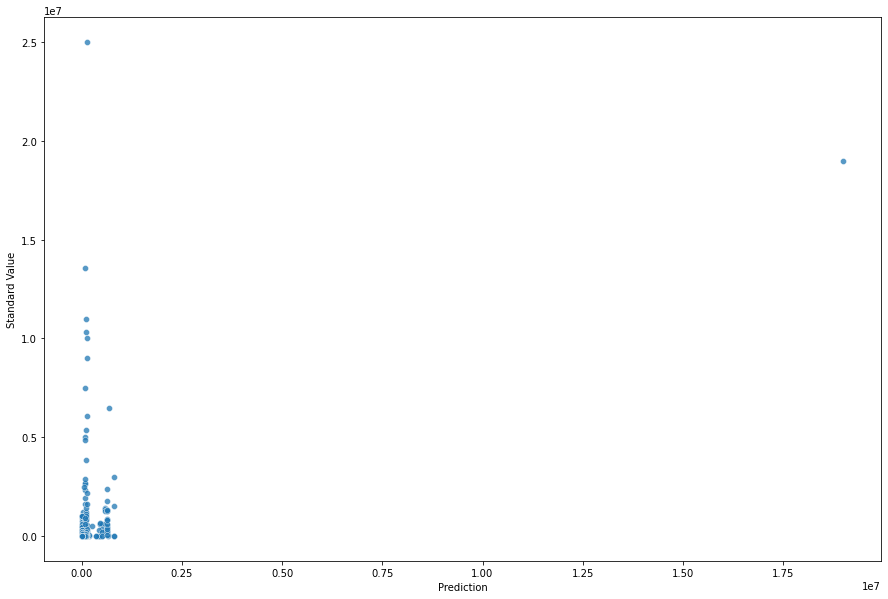

In [66]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="Standard Value",
                      data=train_resultsSV,
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

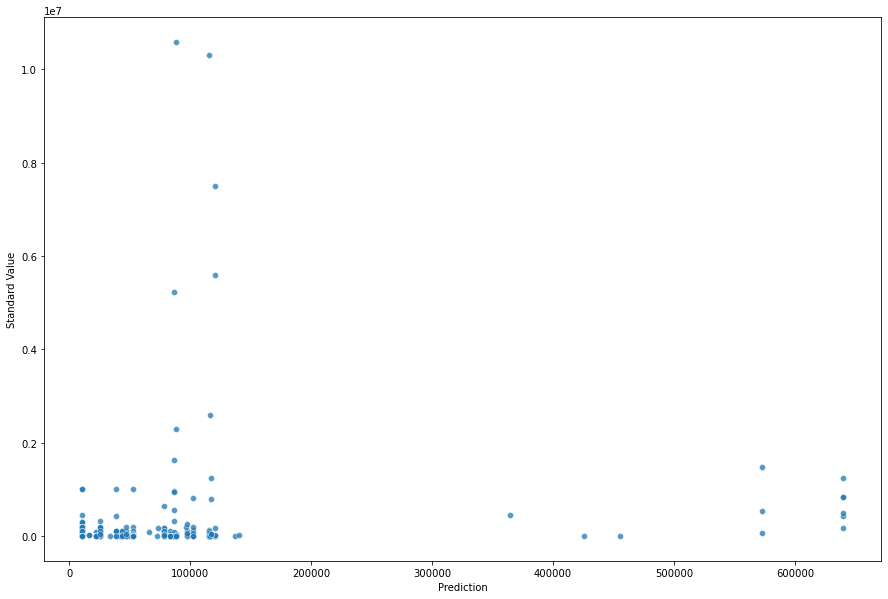

In [67]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="Standard Value",
                      data=test_resultsSV,
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

Není vidět korelaci mezi skutečnou hodnotou a predikcí.

Bylo rozhodnuto nějak předzpracovat data. Je udělána PCA a vybrány 10 prvních komponent, aby zmenšit dimenzionalitu.

In [27]:
XnormSV = preprocessing.normalize(XSV)
Xnorm_testSV = preprocessing.normalize(X_testSV)


XSV_pca = decomposition.PCA(n_components=10)
X_testSV_pca = decomposition.PCA(n_components=10)

XSV_pca.fit(XnormSV)
X_testSV_pca.fit(Xnorm_testSV)

pXSV = pd.DataFrame(XSV_pca.transform(XnormSV), columns=[f"nPCA_{x}" for x in range(1, 11)])
pX_testSV = pd.DataFrame(X_testSV_pca.transform(Xnorm_testSV), columns=[f"nPCA_{x}" for x in range(1, 11)])

In [29]:
for i,klass in enumerate(regr):
    tune_model = ms.GridSearchCV(klass[1], param_grid=parametry[i], scoring = 'r2', cv = cv_split)
    tune_model.fit(pXSV, ySV)
    print('r2', klass[0], 'na trenovací množině:', tune_model.score(pXSV, ySV))
    print('r2', klass[0], 'na validační množině:', tune_model.best_score_)
    print(klass[0], tune_model.best_params_)
    print()

r2 SVR na trenovací množině: -0.004871031626664468
r2 SVR na validační množině: -0.0077740341650800815
SVR {'kernel': 'poly'}

r2 RandomForestRegressor na trenovací množině: 0.10422802552201949
r2 RandomForestRegressor na validační množině: -0.36848817256198757
RandomForestRegressor {'max_depth': 1, 'n_estimators': 16, 'random_state': 2307}

r2 GradientBoostingRegressor na trenovací množině: 0.010394681277247741
r2 GradientBoostingRegressor na validační množině: -0.003243026603509254
GradientBoostingRegressor {'learning_rate': 0.01, 'n_estimators': 1, 'random_state': 2307}

r2 AdaBoostRegressor na trenovací množině: 0.5235054221666327
r2 AdaBoostRegressor na validační množině: -0.21758027609704367
AdaBoostRegressor {'learning_rate': 0.01, 'n_estimators': 6, 'random_state': 2307}



Modely ted jsou jěště horší.

Pomocí SelectKBest jsou vybrány 15 příznaky, které jsou nejvice vysvetlujou cilovou promennou.

In [41]:
the_best = SelectKBest(score_func=f_regression,k=15).fit(XSV, ySV)

best_columns = the_best.get_support(indices=True)

XSV_best = XSV.iloc[:, best_columns] 
X_testSV_best = X_testSV.iloc[:, best_columns] 

/opt/bio-class/miniconda/envs/cdd/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


In [42]:
for i,klass in enumerate(regr):
    tune_model = ms.GridSearchCV(klass[1], param_grid=parametry[i], scoring = 'r2', cv = cv_split)
    tune_model.fit(XSV_best, ySV)
    print('r2', klass[0], 'na trenovací množině:', tune_model.score(XSV_best, ySV))
    print('r2', klass[0], 'na validační množině:', tune_model.best_score_)
    print(klass[0], tune_model.best_params_)
    print()

r2 SVR na trenovací množině: -0.0047491846664291515
r2 SVR na validační množině: -0.007496067092457928
SVR {'kernel': 'linear'}

r2 RandomForestRegressor na trenovací množině: 0.020232029979666666
r2 RandomForestRegressor na validační množině: 0.0015557440106124876
RandomForestRegressor {'max_depth': 1, 'n_estimators': 51, 'random_state': 2307}

r2 GradientBoostingRegressor na trenovací množině: 0.10695673839797859
r2 GradientBoostingRegressor na validační množině: 0.009034188447283653
GradientBoostingRegressor {'learning_rate': 0.01, 'n_estimators': 36, 'random_state': 2307}

r2 AdaBoostRegressor na trenovací množině: 0.20825999490807767
r2 AdaBoostRegressor na validační množině: 0.022299606449428314
AdaBoostRegressor {'learning_rate': 0.01, 'n_estimators': 16, 'random_state': 2307}



Nic lepsího ve vysledkach neni.

## Prediction of pChEMBL Value

Opakovaní předchozího postupu.

#### Rozdělení dat na trénovací a testovací

In [50]:
X_dataPV = df[df["pChEMBL Value"]>0][(f"MQN_{x}" for x in range(1, 43))]
y_dataPV = df[df["pChEMBL Value"]>0]["pChEMBL Value"]

XPV, X_testPV, yPV, y_testPV = ms.train_test_split(X_dataPV, y_dataPV, test_size=0.25, random_state=2307) 

#### Ladění hyperparametrů, účení, určeni přesnosti na trénovací množině a průměrnou přesnosti cross-validation pomocí GridSearchCV. Výběr lepšího modelu.

In [32]:
for i,klass in enumerate(regr):
    tune_model = ms.GridSearchCV(klass[1], param_grid=parametry[i], scoring = 'r2', cv = cv_split)
    tune_model.fit(XPV, yPV)
    print('r2', klass[0], 'na trenovací množině:', tune_model.score(XPV, yPV))
    print('r2', klass[0], 'na validační množině:', tune_model.best_score_)
    print(klass[0], tune_model.best_params_)
    print()

r2 SVR na trenovací množině: 0.25781684033579755
r2 SVR na validační množině: 0.24303523108668748
SVR {'kernel': 'rbf'}

r2 RandomForestRegressor na trenovací množině: 0.2804008207072254
r2 RandomForestRegressor na validační množině: 0.26907597225107627
RandomForestRegressor {'max_depth': 4, 'n_estimators': 96, 'random_state': 2307}

r2 GradientBoostingRegressor na trenovací množině: 0.570386077124282
r2 GradientBoostingRegressor na validační množině: 0.464592489449497
GradientBoostingRegressor {'learning_rate': 0.5, 'n_estimators': 96, 'random_state': 2307}

r2 AdaBoostRegressor na trenovací množině: 0.27541868126520963
r2 AdaBoostRegressor na validační množině: 0.26660442679458085
AdaBoostRegressor {'learning_rate': 0.3, 'n_estimators': 51, 'random_state': 2307}



Nejlepším modelem na základě r2 na validační množině je GradientBoostingRegressor.
Přesnost AdaBoostRegressor na validační množině: 0.464592489449497. To je mnohem lepší, než podařilo predikovat Standard Value.

GradientBoostingRegressor {'learning_rate': 0.5, 'n_estimators': 96, 'random_state': 2307}

Odhadování přesnosti nejlepšího modelu pomocí testovací množiny.

In [66]:
finaly_good_modelPV = ensemble.GradientBoostingRegressor(learning_rate=0.5, n_estimators=96, random_state=2307)
finaly_good_modelPV.fit(XPV, yPV)

print(metrics.r2_score(y_testPV, finaly_good_modelPV.predict(X_testPV)))

0.45645895232472944


In [67]:
train_resultsPV = pd.DataFrame(finaly_good_modelPV.predict(XPV))
train_resultsPV.columns = ["Prediction"]
train_resultsPV["pChEMBL Value"] = list(yPV)

test_resultsPV = pd.DataFrame(finaly_good_modelPV.predict(X_testPV))
test_resultsPV.columns = ["Prediction"]
test_resultsPV["pChEMBL Value"] = list(y_testPV)

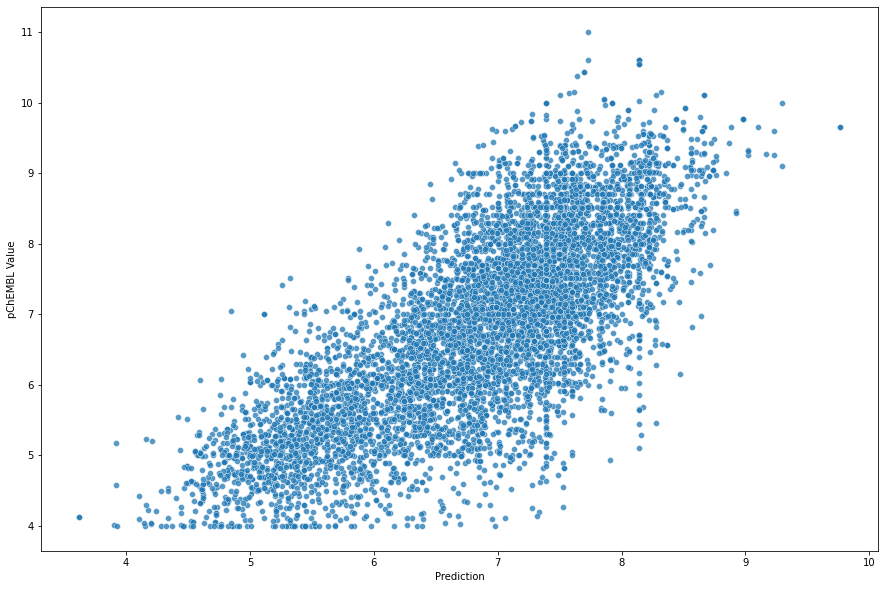

In [68]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="pChEMBL Value",
                      data=train_resultsPV,
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

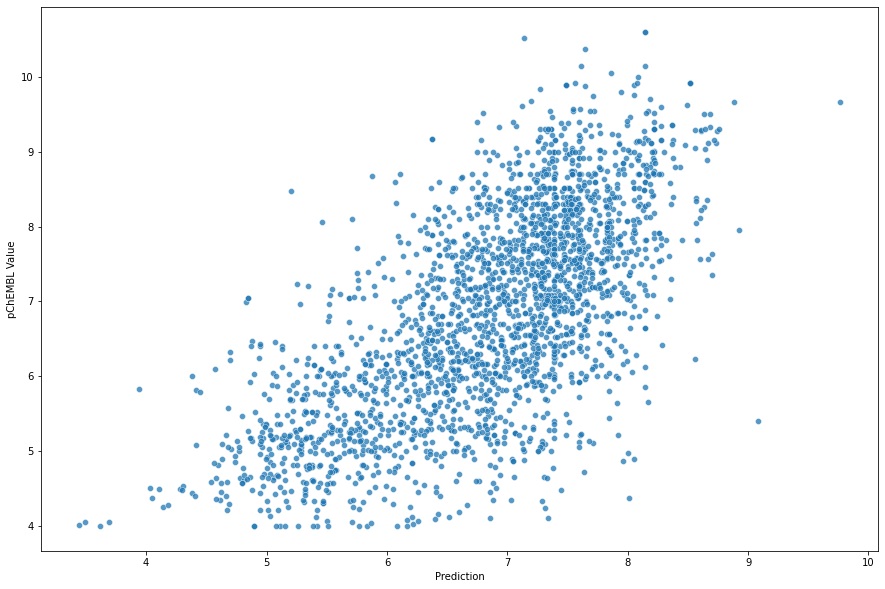

In [69]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="pChEMBL Value",
                      data=test_resultsPV,
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

In [44]:
XnormPV = preprocessing.normalize(XPV)
Xnorm_testPV = preprocessing.normalize(X_testPV)


XPV_pca = decomposition.PCA(n_components=10)
X_testPV_pca = decomposition.PCA(n_components=10)

XPV_pca.fit(XnormSV)
X_testPV_pca.fit(Xnorm_testSV)

pXPV = pd.DataFrame(XPV_pca.transform(XnormPV), columns=[f"nPCA_{x}" for x in range(1, 11)])
pX_testPV = pd.DataFrame(X_testPV_pca.transform(Xnorm_testPV), columns=[f"nPCA_{x}" for x in range(1, 11)])

In [45]:
for i,klass in enumerate(regr):
    tune_model = ms.GridSearchCV(klass[1], param_grid=parametry[i], scoring = 'r2', cv = cv_split)
    tune_model.fit(pXPV, yPV)
    print('r2', klass[0], 'na trenovací množině:', tune_model.score(pXPV, yPV))
    print('r2', klass[0], 'na validační množině:', tune_model.best_score_)
    print(klass[0], tune_model.best_params_)
    print()

r2 SVR na trenovací množině: 0.416143733282091
r2 SVR na validační množině: 0.36117288680261445
SVR {'kernel': 'rbf'}

r2 RandomForestRegressor na trenovací množině: 0.23513996830487816
r2 RandomForestRegressor na validační množině: 0.21397590669224612
RandomForestRegressor {'max_depth': 4, 'n_estimators': 96, 'random_state': 2307}

r2 GradientBoostingRegressor na trenovací množině: 0.5230813086399806
r2 GradientBoostingRegressor na validační množině: 0.384692937536974
GradientBoostingRegressor {'learning_rate': 0.3, 'n_estimators': 96, 'random_state': 2307}

r2 AdaBoostRegressor na trenovací množině: 0.2084573163358523
r2 AdaBoostRegressor na validační množině: 0.1938496510334395
AdaBoostRegressor {'learning_rate': 0.1, 'n_estimators': 96, 'random_state': 2307}



In [59]:
the_bestPV = SelectKBest(score_func=f_regression,k=15).fit(XPV, yPV)

best_columnsPV = the_bestPV.get_support(indices=True)

XPV_best = XPV.iloc[:, best_columnsPV] 
X_testPV_best = X_testPV.iloc[:, best_columnsPV] 

/opt/bio-class/miniconda/envs/cdd/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


In [60]:
for i,klass in enumerate(regr):
    tune_model = ms.GridSearchCV(klass[1], param_grid=parametry[i], scoring = 'r2', cv = cv_split)
    tune_model.fit(XPV_best, yPV)
    print('r2', klass[0], 'na trenovací množině:', tune_model.score(XPV_best, yPV))
    print('r2', klass[0], 'na validační množině:', tune_model.best_score_)
    print(klass[0], tune_model.best_params_)
    print()

r2 SVR na trenovací množině: 0.22829195456415896
r2 SVR na validační množině: 0.2155677477633506
SVR {'kernel': 'rbf'}

r2 RandomForestRegressor na trenovací množině: 0.2726758119238677
r2 RandomForestRegressor na validační množině: 0.2611457948706959
RandomForestRegressor {'max_depth': 4, 'n_estimators': 86, 'random_state': 2307}

r2 GradientBoostingRegressor na trenovací množině: 0.5192962112202386
r2 GradientBoostingRegressor na validační množině: 0.4123609437734361
GradientBoostingRegressor {'learning_rate': 0.5, 'n_estimators': 96, 'random_state': 2307}

r2 AdaBoostRegressor na trenovací množině: 0.2538710250372347
r2 AdaBoostRegressor na validační množině: 0.24519256981293855
AdaBoostRegressor {'learning_rate': 0.1, 'n_estimators': 76, 'random_state': 2307}



Nepovedlo se najít lepší model po zpracování dat. 